<a href="https://colab.research.google.com/github/hannasorolee/toronto-airbnb-price-predictor/blob/main/capstone_code_modeling_hanna_lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Google Sheets as CSV
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)


# Define core columns
core_columns = [
    "id", "name", "description","neighborhood_overview",
    "neighbourhood_cleansed","room_type", "accommodates", "bedrooms",
    "bathrooms", "price", "minimum_nights", "host_is_superhost",
    "number_of_reviews", "review_scores_rating", "reviews_per_month"
]

tor = tor[core_columns]

# Preview top 10 rows
print("Top 10 sample rows:\n")
display(tor.head(10))


# Generate describe and null/unique table
describe_df = tor.describe(include='all').transpose()


# Add nulls and unique values
describe_df['nulls'] = tor.isna().sum()
describe_df['unique'] = tor.nunique()


# Reorder columns for clarity
summary = describe_df[['count', 'unique', 'nulls', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("Summary Statistics for Core Columns:\n")
display(summary)


Top 10 sample rows:



,id,name,description,neighborhood_overview,neighbourhood_cleansed,room_type,accommodates,bedrooms,bathrooms,price,minimum_nights,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month
0,1419.0,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,Little Portugal,Entire home/apt,10,5.0,NaN,NaN,28,f,6,5.00,0.05
1,8077.0,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,Waterfront Communities-The Island,Private room,2,NaN,NaN,NaN,180,f,169,4.84,0.88
2,26654.0,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,Waterfront Communities-The Island,Entire home/apt,4,2.0,1.0,$158.00,28,t,45,4.80,0.26
3,27423.0,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,South Riverdale,Entire home/apt,1,NaN,NaN,NaN,365,f,32,4.94,0.17
4,30931.0,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,Waterfront Communities-The Island,Entire home/apt,2,1.0,NaN,NaN,180,f,1,5.00,0.01
5,40456.0,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,This is Nice Neighborhood located in Downtown ...,South Parkdale,Entire home/apt,5,2.0,NaN,NaN,750,t,113,4.64,0.62
6,43964.0,Cozy & Private Basement Apartment free parking,Cozy 2-Bedroom Basement Suite in Wexford-Maryv...,- Super quiet family-friendly neighborhood<br ...,Wexford/Maryvale,Entire home/apt,4,2.0,0.0,$143.00,2,f,67,4.96,0.65
7,44452.0,Yonge & Bloor Studio Skyline,NaN,NaN,Rosedale-Moore Park,Entire home/apt,2,1.0,1.0,$94.00,28,f,67,4.18,0.37
8,45399.0,Fountain View Studio - Eaton center,"Open Space studio style, Big windows, calm & r...","Amazing neighbourhood, very central and walkin...",Bay Street Corridor,Entire home/apt,3,0.0,1.0,$120.00,28,f,89,4.17,0.50
9,45893.0,Yonge & Bloor Lakeview Master BR,NaN,NaN,Rosedale-Moore Park,Private room,1,1.0,1.0,$69.00,28,f,24,4.40,0.13


Summary Statistics for Core Columns:



,count,unique,nulls,mean,std,min,25%,50%,75%,max
id,21092.0,21092,0,645421235516480000.0,554624590881750272.0,1419.0,34091273.5,798838175312913408.0,1165362628563508480.0,1438745508220814592.0
name,21092,20469,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,20686,18365,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_overview,9588,8025,11504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_cleansed,21092,140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_type,21092,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,21092.0,16,0,3.188697,2.022056,1.0,2.0,2.0,4.0,16.0
bedrooms,19342.0,13,1750,1.500982,0.990192,0.0,1.0,1.0,2.0,50.0
bathrooms,15359.0,16,5733,1.287551,0.623595,0.0,1.0,1.0,1.5,20.0
price,15365,785,5727,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Load Google Sheets as CSV
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)


# 2. Define core columns
core_columns = [
    "id", "name", "description","neighborhood_overview",
    "neighbourhood_cleansed","room_type", "accommodates", "bedrooms",
    "bathrooms", "price", "minimum_nights", "host_is_superhost",
    "number_of_reviews", "review_scores_rating", "reviews_per_month"
]

tor = tor[core_columns]

#Clean 'price'
tor["price"] = tor["price"].replace('[\$,]', '', regex=True).astype(float)

#Filter only 1-bedroom
tor_1bd = tor[tor["bedrooms"].fillna(0) == 1].copy()

#change superhost t and f to 1 and 0
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].map({'t': 1, 'f': 0})
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].fillna(0).astype(int)


# 3. Preview top 10 rows
print("Top 10 sample rows:\n")
display(tor_core.head(10))


# 4. Generate describe and null/unique table
describe_df = tor_core.describe(include='all').transpose()


# Add nulls and unique values
describe_df['nulls'] = tor_core.isna().sum()
describe_df['unique'] = tor_core.nunique()


# Reorder columns for clarity
summary = describe_df[['count', 'unique', 'nulls', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("Summary Statistics for Core Columns:\n")
display(summary)


Top 10 sample rows:



,id,name,description,neighborhood_overview,neighbourhood_cleansed,room_type,accommodates,bedrooms,bathrooms,price,minimum_nights,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month
0,1419.0,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,Little Portugal,Entire home/apt,10,5.0,NaN,NaN,28,f,6,5.00,0.05
1,8077.0,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,Waterfront Communities-The Island,Private room,2,NaN,NaN,NaN,180,f,169,4.84,0.88
2,26654.0,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,Waterfront Communities-The Island,Entire home/apt,4,2.0,1.0,$158.00,28,t,45,4.80,0.26
3,27423.0,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,South Riverdale,Entire home/apt,1,NaN,NaN,NaN,365,f,32,4.94,0.17
4,30931.0,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,Waterfront Communities-The Island,Entire home/apt,2,1.0,NaN,NaN,180,f,1,5.00,0.01
5,40456.0,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,This is Nice Neighborhood located in Downtown ...,South Parkdale,Entire home/apt,5,2.0,NaN,NaN,750,t,113,4.64,0.62
6,43964.0,Cozy & Private Basement Apartment free parking,Cozy 2-Bedroom Basement Suite in Wexford-Maryv...,- Super quiet family-friendly neighborhood<br ...,Wexford/Maryvale,Entire home/apt,4,2.0,0.0,$143.00,2,f,67,4.96,0.65
7,44452.0,Yonge & Bloor Studio Skyline,NaN,NaN,Rosedale-Moore Park,Entire home/apt,2,1.0,1.0,$94.00,28,f,67,4.18,0.37
8,45399.0,Fountain View Studio - Eaton center,"Open Space studio style, Big windows, calm & r...","Amazing neighbourhood, very central and walkin...",Bay Street Corridor,Entire home/apt,3,0.0,1.0,$120.00,28,f,89,4.17,0.50
9,45893.0,Yonge & Bloor Lakeview Master BR,NaN,NaN,Rosedale-Moore Park,Private room,1,1.0,1.0,$69.00,28,f,24,4.40,0.13


Summary Statistics for Core Columns:



,count,unique,nulls,mean,std,min,25%,50%,75%,max
id,21092.0,21092,0,645421235516480000.0,554624590881750272.0,1419.0,34091273.5,798838175312913408.0,1165362628563508480.0,1438745508220814592.0
name,21092,20469,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,20686,18365,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_overview,9588,8025,11504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_cleansed,21092,140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_type,21092,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,21092.0,16,0,3.188697,2.022056,1.0,2.0,2.0,4.0,16.0
bedrooms,19342.0,13,1750,1.500982,0.990192,0.0,1.0,1.0,2.0,50.0
bathrooms,15359.0,16,5733,1.287551,0.623595,0.0,1.0,1.0,1.5,20.0
price,15365,785,5727,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-50-461876712.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="price_group", palette="Blues_d")


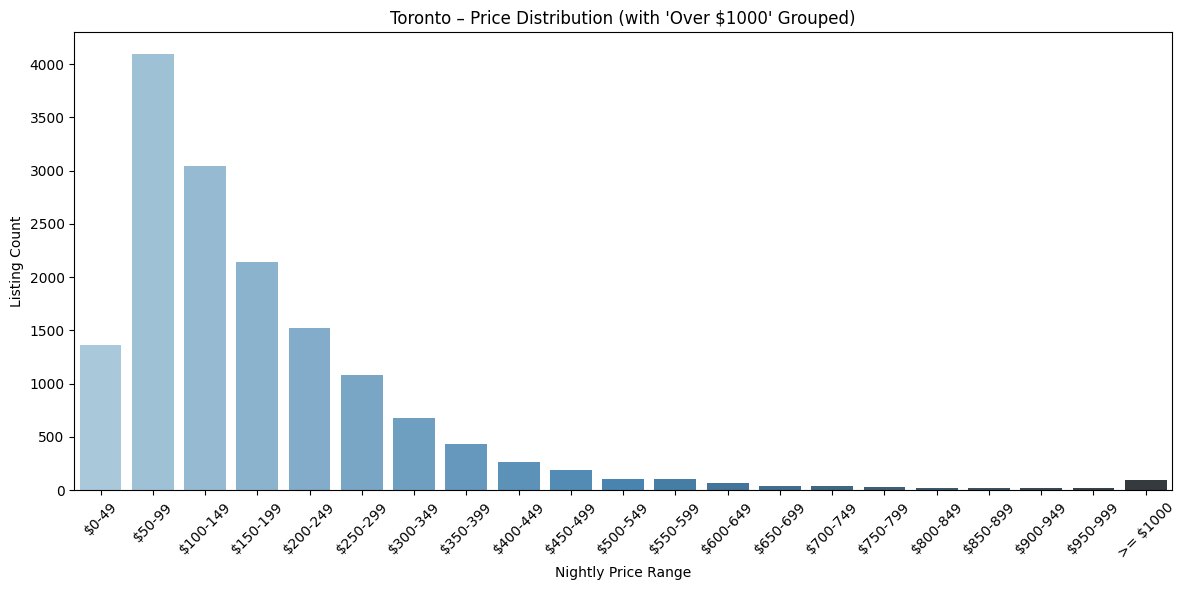

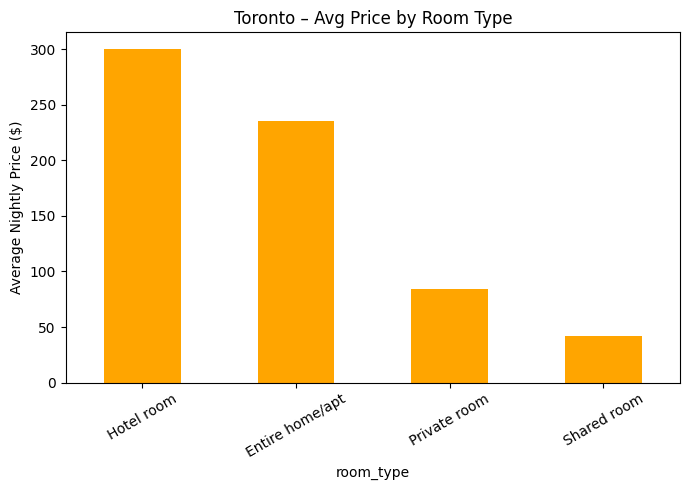

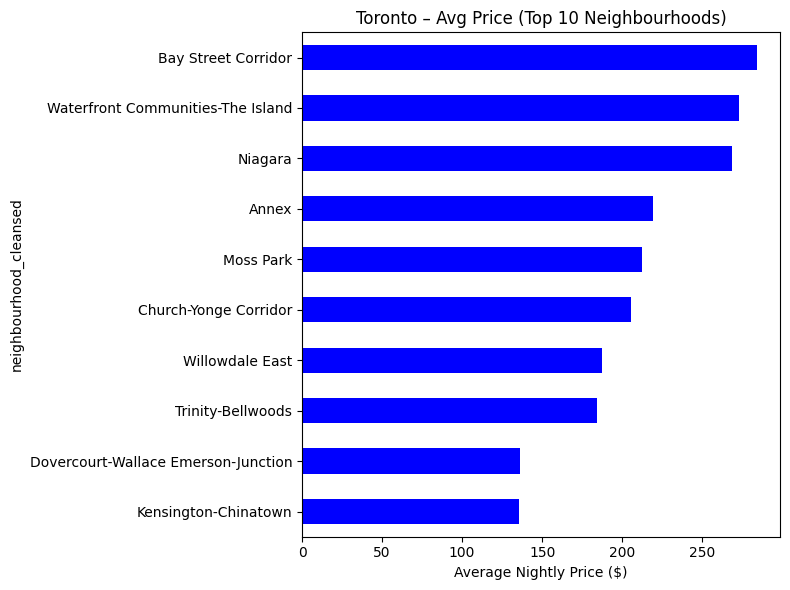

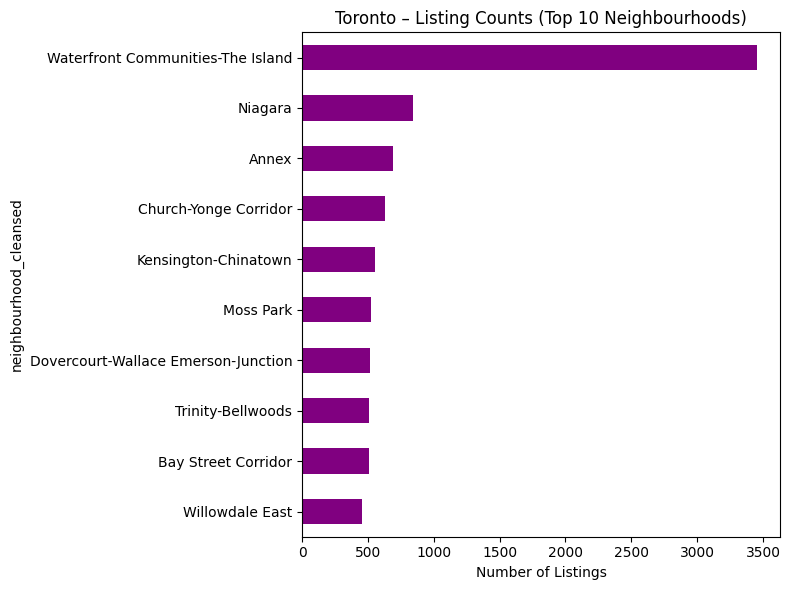

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Google Sheets data (Toronto only)
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)

# 2. Clean 'price' column
tor["price"] = tor["price"].replace('[\$,]', '', regex=True).astype(float)

# 3. Helper: Save and show plots
def save_and_show(fig, filename):
    fig.savefig(f"{filename}.png", bbox_inches="tight")
    plt.show()

# 4. Price Distribution – Group 1000+ into final bin
def plot_price_distribution_binned():
    df = tor.copy()
    df = df[df["price"] > 0]

    bin_edges = list(range(0, 1000 + 1, 50)) + [float('inf')]
    bin_labels = [f"${i}-{i+49}" for i in range(0, 1000, 50)] + [">= $1000"]
    df["price_group"] = pd.cut(df["price"], bins=bin_edges, labels=bin_labels, right=False)

    fig = plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x="price_group", palette="Blues_d")
    plt.title("Toronto – Price Distribution (with 'Over $1000' Grouped)")
    plt.xlabel("Nightly Price Range")
    plt.ylabel("Listing Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_and_show(fig, "price_distribution_binned")

# 5. Average Price by Room Type
def plot_avg_price_by_room_type():
    tor_mean = tor.groupby("room_type")["price"].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(7, 5))
    tor_mean.plot(kind="bar", ax=ax, color="orange")
    ax.set_title("Toronto – Avg Price by Room Type")
    ax.set_ylabel("Average Nightly Price ($)")
    ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    save_and_show(fig, "avg_price_by_room_type")

# 6. Average Price by Top Neighbourhoods
def plot_avg_price_by_top_neighbourhoods():
    tor_top10 = tor["neighbourhood_cleansed"].value_counts().head(10).index
    tor_avg = tor[tor["neighbourhood_cleansed"].isin(tor_top10)]\
        .groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(8, 6))
    tor_avg.plot(kind="barh", ax=ax, color='blue')
    ax.set_title("Toronto – Avg Price (Top 10 Neighbourhoods)")
    ax.set_xlabel("Average Nightly Price ($)")
    ax.invert_yaxis()
    plt.tight_layout()
    save_and_show(fig, "avg_price_by_top_neighbourhoods")

# 7. Count of Listings per Top 10 Neighbourhoods
def plot_listing_counts_by_top_neighbourhoods():
    tor_top10 = tor["neighbourhood_cleansed"].value_counts().head(10)
    fig, ax = plt.subplots(figsize=(8, 6))
    tor_top10.sort_values(ascending=False).plot(kind="barh", ax=ax, color='purple')
    ax.set_title("Toronto – Listing Counts (Top 10 Neighbourhoods)")
    ax.set_xlabel("Number of Listings")
    ax.invert_yaxis()
    plt.tight_layout()
    save_and_show(fig, "listing_counts_by_top_neighbourhoods")

# 8. Run All Visuals
plot_price_distribution_binned()
plot_avg_price_by_room_type()
plot_avg_price_by_top_neighbourhoods()
plot_listing_counts_by_top_neighbourhoods()


In [ ]:
#GOOD#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#Load dataset from Google Sheets
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)

#Clean 'price' and 'bathrooms_text' fields
tor["price"] = tor["price"].replace('[\$,]', '', regex=True).astype(float)
tor["bathrooms"] = tor["bathrooms_text"].str.extract(r'(\d+\.?\d*)')[0].astype(float)

#Filter only 1-bedroom
tor_1bd = tor[tor["bedrooms"].fillna(0) == 1].copy()

#change superhost t and f to 1 and 0
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].map({'t': 1, 'f': 0})
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].fillna(0).astype(int)


# 4. Select modeling features
df_model_1 = tor_1bd[[
    "price", "bathrooms","minimum_nights",
    "number_of_reviews", "review_scores_rating"
]].dropna()

# 6. Split into X and y
X = df_model_1.drop("price", axis=1)
y = df_model_1["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# 8. Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# 9. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# 10. XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

def evaluate(name, model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.3f}\n")

evaluate("Linear Regression", lr)
evaluate("Decision Tree (max_depth=5)", dt)
evaluate("Random Forest (max_depth=10)", rf)
evaluate("XGBoost", xgb)

🔹 Linear Regression
   RMSE: 146.42
   R² Score: -0.106

🔹 Decision Tree (max_depth=5)
   RMSE: 153.39
   R² Score: -0.214

🔹 Random Forest (max_depth=10)
   RMSE: 187.00
   R² Score: -0.805

🔹 XGBoost
   RMSE: 153.58
   R² Score: -0.217



In [ ]:
#GOOD##
####REMOVE OUTLIERS####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

# 4. Select columns including text fields
df_model_2 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost",
    "number_of_reviews", "review_scores_rating"
]].dropna()


# Exclude suspiciously outliars
price_cap = df_model_2["price"].quantile(0.95)
price_low = df_model_2["price"].quantile(0.05)
df_model_2 = df_model_2[df_model_2["price"] <= price_cap]
df_model_2 = df_model_2[df_model_2["price"] > price_low]


# 7. Final dataset

X = df_model_2.drop("price", axis=1)
y = df_model_2["price"]

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Train models
lr = LinearRegression().fit(X_train, y_train)
dt = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42).fit(X_train, y_train)

# 10. Evaluate
def evaluate(name, model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.3f}\n")

evaluate("Linear Regression", lr)
evaluate("Decision Tree (max_depth=5)", dt)
evaluate("Random Forest (max_depth=10)", rf)
evaluate("XGBoost", xgb)


🔹 Linear Regression
   RMSE: 58.38
   R² Score: 0.012

🔹 Decision Tree (max_depth=5)
   RMSE: 57.15
   R² Score: 0.053

🔹 Random Forest (max_depth=10)
   RMSE: 57.82
   R² Score: 0.031

🔹 XGBoost
   RMSE: 57.36
   R² Score: 0.046



In [ ]:
#GOOD#
#### ADD ROOM TYPE ####
# 4. Select modeling features
df_model_3 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost", "accommodates", "minimum_nights", "room_type",
    "neighbourhood_cleansed", "number_of_reviews", "review_scores_rating"
]].dropna()

# Exclude suspiciously outliars
price_cap = df_model_3["price"].quantile(0.95)
price_low = df_model_3["price"].quantile(0.05)
df_model_3 = df_model_3[df_model_3["price"] <= price_cap]
df_model_3 = df_model_3[df_model_3["price"] > price_low]


# 5. One-hot encode 'neighbourhood_cleansed'
df_model_3 = pd.get_dummies(df_model_3, columns=["neighbourhood_cleansed", "accommodates", "room_type"], drop_first=True)

# 6. Split into X and y
X = df_model_3.drop("price", axis=1)
y = df_model_3["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# 8. Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# 9. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# 10. XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)


# 9. Print results
print("🔹 Linear Regression")
print(f"   RMSE: {lr_rmse:.2f}")
print(f"   R² Score: {lr_r2:.3f}\n")

print("🔹 Decision Tree (max_depth=5)")
print(f"   RMSE: {dt_rmse:.2f}")
print(f"   R² Score: {dt_r2:.3f}\n")

print(f"🔹 Random Forest (max_depth=10)")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R² Score: {rf_r2:.3f}\n")

print("🔹 XGBoost Regressor")
print(f"   RMSE: {xgb_rmse:.2f}")
print(f"   R² Score: {xgb_r2:.3f}")


🔹 Linear Regression
   RMSE: 39.71
   R² Score: 0.543

🔹 Decision Tree (max_depth=5)
   RMSE: 40.75
   R² Score: 0.519

🔹 Random Forest (max_depth=10)
  RMSE: 38.29
  R² Score: 0.575

🔹 XGBoost Regressor
   RMSE: 37.13
   R² Score: 0.600


In [ ]:
#GOOD#
####ADD TF-IDF####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

# 4. Select columns including text fields
df_model_4 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost", "accommodates", "minimum_nights", "room_type",
    "neighbourhood_cleansed", "number_of_reviews", "review_scores_rating",
    "name", "description", "neighborhood_overview"
]].dropna()

# Exclude suspiciously outliars
price_cap = df_model_4["price"].quantile(0.95)
price_low = df_model_4["price"].quantile(0.05)
df_model_4 = df_model_4[df_model_4["price"] <= price_cap]
df_model_4 = df_model_4[df_model_4["price"] > price_low]


# 5. One-hot encoding
df_model_4 = pd.get_dummies(df_model_4, columns=["neighbourhood_cleansed", "accommodates", "room_type"], drop_first=True)

# 6. TF-IDF: Combine all 3 text fields
combined_text = (
    df_model_4["name"].fillna('') + " " +
    df_model_4["description"].fillna('') + " " +
    df_model_4["neighborhood_overview"].fillna('')
)

tfidf = TfidfVectorizer(max_features=200, stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined_text)
text_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df_model_4.index)

# 7. Final dataset
df_model_4 = df_model_4.drop(columns=["name", "description", "neighborhood_overview"])
X = pd.concat([df_model_4.drop("price", axis=1), text_matrix], axis=1)
y = df_model_4["price"]

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Train models
lr = LinearRegression().fit(X_train, y_train)
dt = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42).fit(X_train, y_train)

# 10. Evaluate
def evaluate(name, model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.3f}\n")

evaluate("Linear Regression", lr)
evaluate("Decision Tree (max_depth=5)", dt)
evaluate("Random Forest (max_depth=10)", rf)
evaluate("XGBoost", xgb)

#Here are the top TF-IDF features and their importances in your XGBoost model.
#As you can see, all the values are zero—this means that the model is not actually using any of the text features to make predictions.
#That's why modifying name, description, or neighborhood_overview in the input had no/negative effect on predicted price.
#The model likely found stronger, more predictive patterns in the structured features like bathrooms, superhost, or number_of_reviews, and is ignoring the text features.
#TF-IDF produces sparse, shallow representations—often useful only when there's rich, varying, and meaningful language. Airbnb listing text might be too generic or noisy.

🔹 Linear Regression
   RMSE: 41.38
   R² Score: 0.496

🔹 Decision Tree (max_depth=5)
   RMSE: 41.14
   R² Score: 0.502

🔹 Random Forest (max_depth=10)
   RMSE: 37.67
   R² Score: 0.582

🔹 XGBoost
   RMSE: 37.10
   R² Score: 0.595



In [ ]:
#### Retrain with non- TF-IDF because TF-IDF modeling was reducing the accuracy ####
X = df_model_3.drop("price", axis=1)
y = df_model_3["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# 8. Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# 9. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# 10. XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)


# 9. Print results
print("🔹 Linear Regression")
print(f"   RMSE: {lr_rmse:.2f}")
print(f"   R² Score: {lr_r2:.3f}\n")

print("🔹 Decision Tree (max_depth=5)")
print(f"   RMSE: {dt_rmse:.2f}")
print(f"   R² Score: {dt_r2:.3f}\n")

print(f"🔹 Random Forest (max_depth=10)")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R² Score: {rf_r2:.3f}\n")

print("🔹 XGBoost Regressor")
print(f"   RMSE: {xgb_rmse:.2f}")
print(f"   R² Score: {xgb_r2:.3f}")

🔹 Linear Regression
   RMSE: 40.58
   R² Score: 0.551

🔹 Decision Tree (max_depth=5)
   RMSE: 40.98
   R² Score: 0.542

🔹 Random Forest (max_depth=10)
  RMSE: 39.00
  R² Score: 0.585

🔹 XGBoost Regressor
   RMSE: 37.68
   R² Score: 0.612


In [ ]:
#GOOD - WENT BACK TO DF3#
#### ADD ROOM TYPE ####
# 4. Select modeling features
df_model_3 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost", "accommodates", "minimum_nights", "room_type",
    "neighbourhood_cleansed", "number_of_reviews", "review_scores_rating"
]].dropna()

# Exclude suspiciously outliars
price_cap = df_model_3["price"].quantile(0.95)
price_low = df_model_3["price"].quantile(0.05)
df_model_3 = df_model_3[df_model_3["price"] <= price_cap]
df_model_3 = df_model_3[df_model_3["price"] > price_low]


# 5. One-hot encode 'neighbourhood_cleansed'
df_model_3 = pd.get_dummies(df_model_3, columns=["neighbourhood_cleansed", "accommodates", "room_type"], drop_first=True)

# 6. Split into X and y
X = df_model_3.drop("price", axis=1)
y = df_model_3["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# 8. Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# 9. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# 10. XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)


# 9. Print results
print("🔹 Linear Regression")
print(f"   RMSE: {lr_rmse:.2f}")
print(f"   R² Score: {lr_r2:.3f}\n")

print("🔹 Decision Tree (max_depth=5)")
print(f"   RMSE: {dt_rmse:.2f}")
print(f"   R² Score: {dt_r2:.3f}\n")

print(f"🔹 Random Forest (max_depth=10)")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R² Score: {rf_r2:.3f}\n")

print("🔹 XGBoost Regressor")
print(f"   RMSE: {xgb_rmse:.2f}")
print(f"   R² Score: {xgb_r2:.3f}")


🔹 Linear Regression
   RMSE: 40.58
   R² Score: 0.551

🔹 Decision Tree (max_depth=5)
   RMSE: 40.98
   R² Score: 0.542

🔹 Random Forest (max_depth=10)
  RMSE: 39.00
  R² Score: 0.585

🔹 XGBoost Regressor
   RMSE: 37.68
   R² Score: 0.612


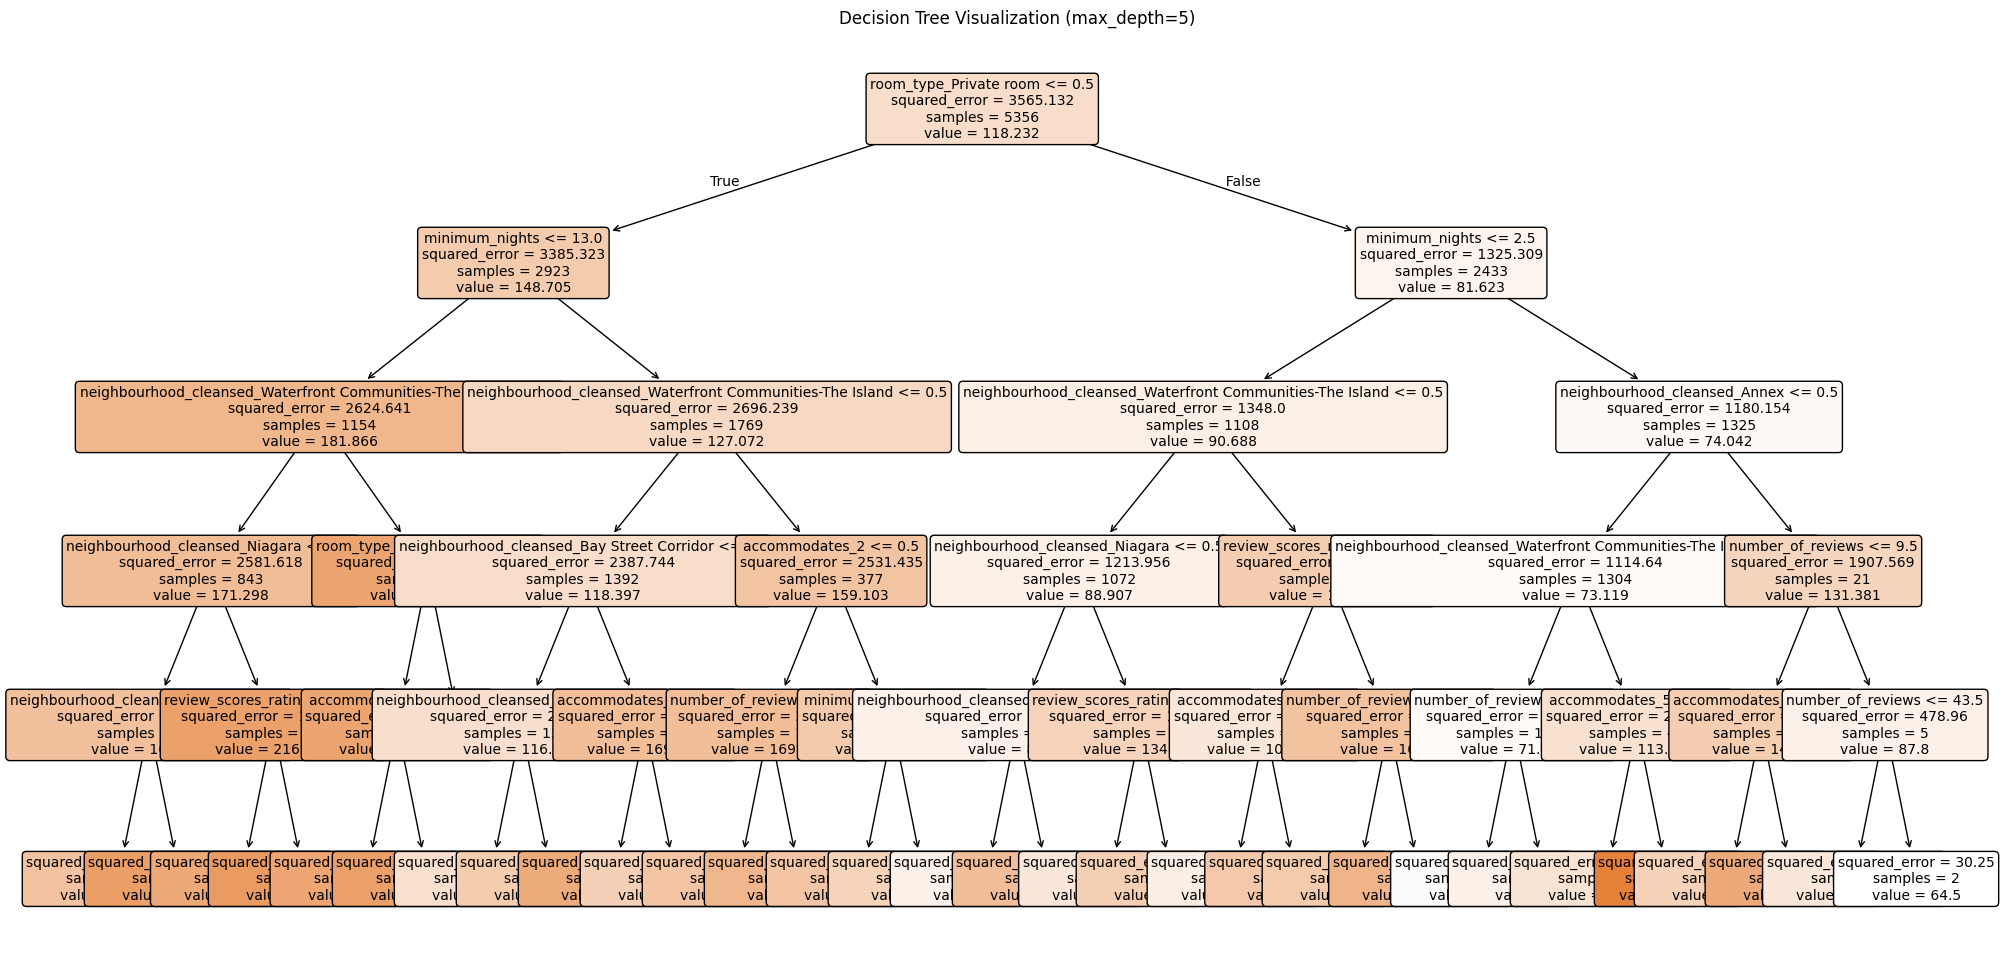


🔍 Decision Tree Rules:
|--- room_type_Private room <= 0.50
|   |--- minimum_nights <= 13.00
|   |   |--- neighbourhood_cleansed_Waterfront Communities-The Island <= 0.50
|   |   |   |--- neighbourhood_cleansed_Niagara <= 0.50
|   |   |   |   |--- neighbourhood_cleansed_Annex <= 0.50
|   |   |   |   |   |--- value: [161.83]
|   |   |   |   |--- neighbourhood_cleansed_Annex >  0.50
|   |   |   |   |   |--- value: [220.71]
|   |   |   |--- neighbourhood_cleansed_Niagara >  0.50
|   |   |   |   |--- review_scores_rating <= 4.87
|   |   |   |   |   |--- value: [202.95]
|   |   |   |   |--- review_scores_rating >  4.87
|   |   |   |   |   |--- value: [224.91]
|   |   |--- neighbourhood_cleansed_Waterfront Communities-The Island >  0.50
|   |   |   |--- room_type_Shared room <= 0.50
|   |   |   |   |--- accommodates_4 <= 0.50
|   |   |   |   |   |--- value: [206.81]
|   |   |   |   |--- accommodates_4 >  0.50
|   |   |   |   |   |--- value: [218.37]
|   |   |   |--- room_type_Shared room >  

In [ ]:
#GOOD#
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree, export_text

# 🔍 Decision Tree Visualization
plt.figure(figsize=(24, 12))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

# 🧠 Text version of decision rules
print("\n🔍 Decision Tree Rules:")
print(export_text(dt, feature_names=list(X.columns)))


🔍 Top 10 Most Important Features:


,Feature,Importance
152,room_type_Private room,0.307191
126,neighbourhood_cleansed_Waterfront Communities-...,0.063505
91,neighbourhood_cleansed_Niagara,0.035471
2,minimum_nights,0.034738
7,neighbourhood_cleansed_Annex,0.029079
10,neighbourhood_cleansed_Bay Street Corridor,0.027555
83,neighbourhood_cleansed_Moss Park,0.017204
27,neighbourhood_cleansed_Church-Yonge Corridor,0.016687
88,neighbourhood_cleansed_New Toronto,0.014542
146,accommodates_4,0.014371


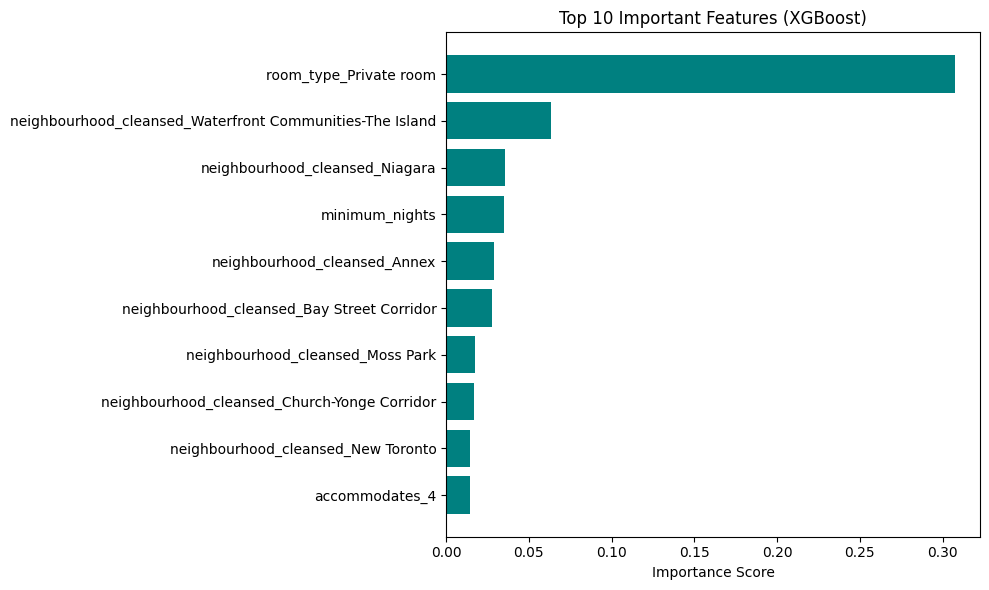

In [ ]:
#GOOD#
# 1. Get feature importances
importances = xgb.feature_importances_

# 2. Match with feature names
feature_names = X_train.columns
importance_xgb = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# 3. Sort by importance
importance_xgb = importance_xgb.sort_values(by="Importance", ascending=False)

# 4. Display top 10
print("🔍 Top 10 Most Important Features:")
display(importance_xgb.head(10))

# 5. Optional: Plot it
plt.figure(figsize=(10, 6))
plt.barh(importance_xgb.head(10)["Feature"], importance_xgb.head(10)["Importance"], color="teal")
plt.xlabel("Importance Score")
plt.title("Top 10 Important Features (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
#GOOD#
def predict_price(user_input, model, feature_columns):
    import pandas as pd

    # 1. Convert to DataFrame
    input_df = pd.DataFrame([user_input])

    # 2. One-hot encode
    input_df = pd.get_dummies(input_df)

    # 3–4. Reindex to match model columns (handles missing and order!)
    input_df = input_df.reindex(columns=feature_columns, fill_value=0)

    # 5. Predict
    prediction = model.predict(input_df)[0]
    return round(prediction, 2)


In [ ]:
#GOOD#
# 🧍🏻 Example user property input
user_input = {
    "room_type_Private room": 0,
    "minimum_nights": 10,
    "neighbourhood_cleansed_Waterfront Communities-The Island": 1,
    "host_is_superhost": 1,
    "accommodates_2": 1,  # One-hot encoded
    "number_of_reviews": 100,
    "review_scores_rating": 100

    # Add any one-hot encoded options used during training
}

# 📈 Predict price
predicted_price = predict_price(user_input, xgb, X.columns)
print(f"Estimated nightly price: ${predicted_price}")


Estimated nightly price: $211.57000732421875


In [ ]:
import joblib
import os

# Create directory to save files (optional)
os.makedirs("streamlit_assets", exist_ok=True)

# 1. Save XGBoost model
joblib.dump(xgb, "streamlit_assets/xgb_model_toronto.joblib")

# 2. Save feature columns
joblib.dump(X.columns.tolist(), "streamlit_assets/feature_columns.joblib")

# 4. Save dropdown values
joblib.dump(sorted(tor_1bd["neighbourhood_cleansed"].dropna().unique().tolist()), "streamlit_assets/neighborhoods.joblib")
joblib.dump(sorted(tor_1bd["accommodates"].dropna().astype(int).unique().tolist()), "streamlit_assets/accommodates.joblib")
joblib.dump(sorted(tor_1bd["room_type"].dropna().unique().tolist()), "streamlit_assets/room_type.joblib")

avg_values = {
    "bathrooms": df_model_4["bathrooms"].mean(),
    "minimum_nights": df_model_4["minimum_nights"].mean(),
    "review_scores_rating": df_model_4["review_scores_rating"].mean(),
    "number_of_reviews": df_model_4["number_of_reviews"].mean()
}

joblib.dump(avg_values, "streamlit_assets/average_values.joblib")

print("✅ All files saved to 'streamlit_assets' folder.")

from google.colab import files
import glob

# Download all saved assets
for file in glob.glob("streamlit_assets/*.joblib"):
    files.download(file)



✅ All files saved to 'streamlit_assets' folder.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>